In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from catboost import CatBoostClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [2]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [4]:
recommender = MainRecommender(data_train_lvl_1)

In [5]:
recommender.get_als_recommendations(2375, N=5)

[871756, 899624, 1106523, 1044078, 844179]

In [6]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [7]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 999270, 1084342, 10355376]

In [8]:
recommender.get_similar_users_recommendation(2375, N=5)

[1097398, 1088771, 1106523, 918638, 1029743]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [9]:
common_users = data_train_lvl_1.user_id.values
data_val_lvl_1 = data_train_lvl_1[data_train_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

In [10]:
result_lvl_1 = data_val_lvl_1.groupby('user_id', sort=False)['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,2375,"[1085983, 827919, 861279, 999999, 930666, 9509..."
1,1364,"[999999, 937406, 947013, 1007929, 1110692, 826..."


In [11]:
def calc_recall(df_result, top_k):
    for col_name in df_result.columns[2:]:
        yield col_name, df_result.apply(lambda row: recall_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()


def calc_precision(df_result, top_k):
    for col_name in df_result.columns[2:]:
        yield col_name, df_result.apply(lambda row: precision_at_k(row[col_name], row['actual'], k=top_k), axis=1).mean()


def make_recommendations(df_result, rec_name_model, N=50):
    rec_name = rec_name_model[0]
    rec_model = rec_name_model[1]
    df_result[rec_name] = df_result['user_id'].apply(lambda x: rec_model(x, N=N))


def fill_top(column, N=5):
    top = np.array(recommender.overall_top_purchases)
    recs = np.array(column)
    flags = np.isin(top, recs, invert=True)
    top = top[flags]
    return np.append(recs, top[:N])


rec_vars = [
    ('own', recommender.get_own_recommendations),
    ('als', recommender.get_als_recommendations),
    ('similar_user', recommender.get_similar_users_recommendation),
    ('similar_item', recommender.get_similar_items_recommendation)
]

for rec_var in rec_vars:
    make_recommendations(result_lvl_1, rec_var)

make_recommendations(result_lvl_1, ('own+top_popular', recommender.get_own_recommendations), N=25)
result_lvl_1['own+top_pop'] = result_lvl_1['own+top_popular'].apply(lambda row: fill_top(row, N=25))

sorted(calc_recall(result_lvl_1, 50), key=lambda x: x[1], reverse=True)

[('own', 0.4995356523469096),
 ('own+top_pop', 0.37833912262409103),
 ('own+top_popular', 0.32284386447478747),
 ('als', 0.14749835502062777),
 ('similar_item', 0.09893975011934819),
 ('similar_user', 0.0803205131522099)]

own_recommendations показали наибольший recall@50, так как формировались по принципу похожести на ближайшего соседа.

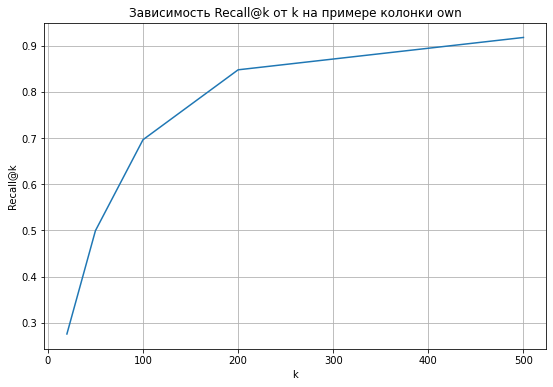

In [12]:
k_list = [20, 50, 100, 200, 500]
scores = []
col = 'own'
for k in k_list:
    make_recommendations(result_lvl_1, rec_vars[0], N=k)
    scores.append(result_lvl_1.apply(lambda row: recall_at_k(row[col], row['actual'], k=k), axis=1).mean())
fig, ax = plt.subplots(1, figsize=(9,6))
ax.plot(k_list, scores)
ax.set_xlabel('k')
ax.set_ylabel('Recall@k')
ax.set_title(f'Зависимость Recall@k от k на примере колонки {col}')
ax.grid()
plt.show()

С увеличением k скорость роста метрики падает. Причина в том, что с увеличением количество кандидатов их качество падает. Разумнее всего выбрать k в диапазоне от 100 до 200, поскольку в таком случае получается достаточно высокий recall без лишних затрат.

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [13]:
sorted(calc_precision(result_lvl_1, 5), key=lambda x: x[1], reverse=True)

[('own', 0.8763927855711424),
 ('own+top_popular', 0.8763927855711424),
 ('own+top_pop', 0.8763927855711424),
 ('als', 0.4466533066132265),
 ('similar_item', 0.2933066132264529),
 ('similar_user', 0.21739478957915837)]

In [14]:
df_match_candidates = pd.DataFrame(data_train_lvl_2['user_id'].unique())
df_match_candidates.columns = ['user_id']
df_match_candidates['candidates'] = df_match_candidates['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)

In [15]:
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_train_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
df_train_lvl_2['target'] = 1
df_train_lvl_2 = df_match_candidates.merge(df_train_lvl_2, on=['user_id', 'item_id'], how='left')
df_train_lvl_2 = df_train_lvl_2.drop_duplicates(subset=['user_id', 'item_id'])
df_train_lvl_2['target'].fillna(0, inplace= True)
df_train_lvl_2 = df_train_lvl_2.merge(item_features, on='item_id', how='left')
df_train_lvl_2 = df_train_lvl_2.merge(user_features, on='user_id', how='left')
df_train_lvl_2= df_train_lvl_2.merge(data_val_lvl_1.groupby('user_id', sort=False)['sales_value'].mean().reset_index(), how='left', on='user_id')
df_train_lvl_2.rename(columns={'sales_value': 'avg_bill'}, inplace=True)
data_val_lvl_1 = data_val_lvl_1.merge(item_features[['item_id', 'department']], how='left', on='item_id')
df_train_lvl_2 = df_train_lvl_2.merge(data_val_lvl_1.groupby(['user_id', 'department'], sort=False)['sales_value'].mean().reset_index(), how='left', on=['user_id', 'department']).rename(columns={'sales_value': 'avg_cat_spendings'})
df_train_lvl_2 = df_train_lvl_2.merge((data_val_lvl_1.groupby('item_id', sort=False)['quantity'].count() / data_val_lvl_1['week_no'].nunique()).reset_index(), how='left', on='item_id')
df_train_lvl_2.rename(columns={'quantity': 'avg_week_purchases'}, inplace=True)
df_train_lvl_2 = df_train_lvl_2.merge((data_val_lvl_1.groupby('department', sort=False)['quantity'].count() / data_val_lvl_1['week_no'].nunique()).reset_index(), how='left', on='department').rename(columns={'quantity': 'avg_week_purchases_cat'})
df_train_lvl_2 = df_train_lvl_2.merge(data_val_lvl_1.groupby('department', sort=False)['sales_value'].mean().reset_index(), how='left', on='department').rename(columns={'sales_value': 'avg_cat_spendings_items'})
df_train_lvl_2 = df_train_lvl_2.merge((data_val_lvl_1.groupby(['user_id', 'department'], sort=False)['quantity'].count() / data_val_lvl_1['week_no'].nunique()).reset_index(), how='left', on=['user_id', 'department']).rename(columns={'quantity': 'user_week_cat_purchase'})

In [16]:
X_train = df_train_lvl_2.iloc[:, 2:].drop('target', axis=1)
y_train = df_train_lvl_2['target']
cat_feats = X_train.columns.tolist()[:-6]
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [17]:
nan_cols = X_train.isna().sum().loc[X_train.isna().sum() > 0].index.tolist()
for col in nan_cols:
    X_train[f'{col}_nan'] = 0
    X_train.loc[X_train[col].isna(), f'{col}_nan'] = 1
    X_train[col].fillna(X_train[col].value_counts().index[0], inplace=True)

In [18]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train = X_train.drop(cat_feats, axis=1).join(pd.DataFrame(encoder.fit_transform(X_train[cat_feats]), columns=encoder.get_feature_names_out(cat_feats)))

In [19]:
model = CatBoostClassifier(iterations=200, silent=True,
                           eta=0.1, task_type='CPU',
                           auto_class_weights='Balanced',
                           random_state=29
            )
model.fit(X_train, y_train)
train_preds = model.predict_proba(X_train)

In [20]:
df_predict_lvl2 = df_train_lvl_2.copy()
df_predict_lvl2['proba_item_purchase'] = train_preds[:, 1]

In [21]:
data_val_lvl_2.loc[~data_val_lvl_2['user_id'].isin(data_train_lvl_2['user_id'])]['user_id'].nunique()

125

In [22]:
class ProcessData:
    
    def __init__(self):
        self.cat_feats = None
        self.data_train_lvl_2 = None
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.item_features = None
        self.nan_cols = None
        self.train_data = None
        self.user_features = None
        

    def _add_features(self, df, is_fit=True):
        df = df[['user_id', 'item_id']].copy()
        df = df.merge(self.item_features, on='item_id', how='left')
        df = df.merge(self.user_features, on='user_id', how='left')
        # Средний чек
        df = df.merge(self.train_data.groupby('user_id', sort=False)['sales_value']. \
                                    mean().reset_index(), how='left', on='user_id')
        df.rename(columns={'sales_value': 'avg_bill'}, inplace=True)  
        # Средняя сумма покупки 1 товара в каждой категории
        df = df.merge(self.train_data.groupby(['user_id', 'department'], sort=False)['sales_value'] \
                                                .mean().reset_index(), how='left', on=['user_id', 'department']). \
                                                rename(columns={'sales_value': 'avg_cat_spendings'})
        # Кол-во покупок в неделю
        df = df.merge((self.train_data.groupby('item_id', sort=False)['quantity'] \
                                                 .count() / self.train_data['week_no'].nunique()).reset_index(), how='left', on='item_id')
        df.rename(columns={'quantity': 'avg_week_purchases'}, inplace=True)
        # Среднее кол-во покупок 1 товара в категории в неделю
        df = df.merge((self.train_data.groupby('department', sort=False)['quantity'] \
                                                 .count() / self.train_data['week_no'].nunique()).reset_index(), \
                                                how='left', on='department').rename(columns={'quantity': 'avg_week_purchases_cat'})
        # Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)
        df = df.merge(self.train_data.groupby('department', sort=False)['sales_value'] \
                                                 .mean().reset_index(), how='left', on='department') \
                                                 .rename(columns={'sales_value': 'avg_cat_spendings_items'})
        # Кол-во покупок юзером конкретной категории в неделю
        df = df.merge((self.train_data.groupby(['user_id', 'department'], sort=False)['quantity'] \
                                                 .count() / self.train_data['week_no'].nunique()).reset_index(), how='left', \
                                                on=['user_id', 'department']).rename(columns={'quantity': 'user_week_cat_purchase'})
        df = df.iloc[:, 2:]
        self.cat_feats = df.columns.tolist()[:-6]
        df[self.cat_feats] = df[self.cat_feats].astype('category')
        if not is_fit:
            self.nan_cols = df.isna().sum().loc[df.isna().sum() > 0].index.tolist()
        for col in self.nan_cols:
            df[f'{col}_nan'] = 0
            df.loc[df[col].isna(), f'{col}_nan'] = 1
            
            if is_fit:
                data_source = self.data_train_lvl_2.copy()
            else:
                data_source = df.copy()     
            df[col].fillna(data_source[col].value_counts().index[0], inplace=True)
        additional_nans = df.isna().sum().loc[df.isna().sum() > 0].index.tolist()
        for col in additional_nans:
            df[col].fillna(data_source[col].value_counts().index[0], inplace=True)
        if not is_fit:
            self.encoder.fit(df[self.cat_feats])
        return df
        
        
    def fit(self, data_train_lvl_2, train_data, user_features, item_features):
        self.data_train_lvl_2 = data_train_lvl_2
        self.train_data = train_data
        self.user_features = user_features
        self.item_features = item_features
        self.data_train_lvl_2 = self._add_features(self.data_train_lvl_2, is_fit=False)
        
    
    def transform(self, X):
        X = self._add_features(X)
        X = X.drop(self.cat_feats, axis=1).join(pd.DataFrame(self.encoder.transform(X[self.cat_feats]), \
                                                    columns=self.encoder.get_feature_names_out(self.cat_feats)))
        return X

In [23]:
data_processor = ProcessData()
data_processor.fit(df_train_lvl_2, data_val_lvl_1, user_features, item_features)
X_train = data_processor.transform(df_train_lvl_2)

In [24]:
result_eval_lvl2 = data_val_lvl_2.groupby('user_id', sort=False)['item_id'].unique().reset_index()
result_eval_lvl2.columns=['user_id', 'actual']
result_eval_lvl2.head(2)

,user_id,actual
0,338,"[840173, 1037348, 5592737, 7441679, 7442317, 1..."
1,2120,"[441768, 480433, 492628, 503227, 525168, 52575..."


In [25]:
%%time
result_eval_lvl2['als'] = result_eval_lvl2['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=50))

CPU times: user 13.8 s, sys: 0 ns, total: 13.8 s
Wall time: 13.8 s


In [26]:
sorted(calc_precision(result_eval_lvl2, 5), key=lambda x: x[1], reverse=True)

[('als', 0.09441176470588236)]

In [27]:
df_match_candidates = result_eval_lvl2.copy().rename(columns={'als': 'candidates'}).drop('actual', axis=1)
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head()

,user_id,item_id
0,338,1068292
0,338,835300
0,338,1084036
0,338,1026118
0,338,13002975


In [28]:
X_valid = data_processor.transform(df_match_candidates)

In [29]:
val_preds = model.predict_proba(X_valid)
df_match_candidates['proba_item_purchase'] = val_preds[:, 1]

In [30]:
def rerank(user_id):
    return df_match_candidates[df_match_candidates['user_id']==user_id].sort_values('proba_item_purchase', ascending=False). \
                                                                                                    head(5).item_id.tolist()

In [31]:
result_eval_lvl2['reranked_als'] = result_eval_lvl2['user_id'].apply(lambda user_id: rerank(user_id))

In [32]:
print(*sorted(calc_precision(result_eval_lvl2, 5), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_als', 0.13186274509803922)
('als', 0.09441176470588236)


Двухуровневая модель дает большую точность рекомендаций.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 